In [1]:
import json
import ROOT
from analysis_framework import Analysis, ILDMC2020Dataset, Dataset

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x702e950


In [ ]:
n_threads = 12
prod = True
no_rvec = False
dataset_path = "data/datasets/miniDSTs/processed-test.json"
output_path = "root://eosproject.cern.ch//eos/experiment/clicdp/data/user/l/lreichen/snapshots/test"
output_meta = "test.json"
checked_output_meta = "checked-test.json"
output_collections = ["PandoraPFOs"]
plot_dir = "plots/pre-selection/test"
if prod:
    dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs.json"
    # dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs-reduced.json"
    # dataset_path = "data/datasets/miniDSTs/processed-no-exc-higgs-reduced500.json"
    output_path = "root://eosproject.cern.ch//eos/experiment/clicdp/data/user/l/lreichen/snapshots/full"
    output_meta = "full.json"
    checked_output_meta = "checked-full.json"
    output_collections = r"^(?!R2jet_lvecs)\w+$"
    plot_dir = "plots/pre-selection/full"


In [3]:
ROOT.EnableImplicitMT(n_threads)

In [4]:
dataset = Dataset.from_json(dataset_path)

In [5]:
analysis = Analysis(dataset)

analysis.init_parameters([
    ("WWCategorisation.RecoCatBasic", "int", "8"),
    ("WWCategorisation.RecoCatAdvanced", "int", "8"),
    ("WWCategorisation.missE", "float", "-42"),
    ("WWCategorisation.misspT", "float", "-42"),
    ("WWCategorisation.mInv", "float", "-42"),
])

In [6]:
# signal cut goes here:
# In this case, we want to require the charged lepton in the final state to be inside of the detector acceptance
# just take the first gen status 1 particle with a fitting pdg value and cut on theta
lep_pdg = 11
# CLD 150 mrad
# ILD ~84 mrad (IDR: 4.8 deg)
acceptance_theta = 0.084
signal_cut = f"""
std::invoke([](auto& genStat, auto& pdg, auto& px, auto& py, auto& pz, auto& m) -> bool {{
auto lepton_mask = genStat == 1 && abs(pdg) == {lep_pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
auto lepton_lvec = ROOT::Math::PxPyPzMVector(px[lepton_idx], py[lepton_idx],
                                             pz[lepton_idx], m[lepton_idx]);
double lepton_theta = lepton_lvec.Theta();
return abs(cos(lepton_theta)) < cos({acceptance_theta});
}}, MCParticlesSkimmed.generatorStatus, MCParticlesSkimmed.PDG, MCParticlesSkimmed.momentum.x, MCParticlesSkimmed.momentum.y, MCParticlesSkimmed.momentum.z, MCParticlesSkimmed.mass)
"""

In [7]:
analysis.set_categories({
    # TODO: actually implement the cut, but I might notice when refactoring the cut-flow...
    # "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": "1 == 1"},
    "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": signal_cut},
    "4f_sl_bkg": {"pattern": r"4f\w+sl", "cut": None }, # inverse signal cut will be applied automatically
    "4f_not_sl": {"pattern": r"4f\w+_(?:h|l)", "cut": None },
    # separate out aa_4f? super low lumi anyway
    "aa2f": {"pattern": "aa_2f", "cut": None},
    # 2f but not aa_2f
    "2f": {"pattern": "(?<!aa_)2f", "cut": None},
    "3f": {"pattern": "ea_3f|ae_3f", "cut": None},
    "5f": {"pattern": "ea_5f|ae_5f", "cut": None},
    "6f": {"pattern": "6f", "cut": None},
    # need to filter out anything ending in _h and 2f_z_eehiq
    "higgs": {"pattern": "[^_e]h", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [8]:
# print(json.dumps(analysis._categories, indent=2))

In [9]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
analysis.Define("n_isomuons", "IsolatedMuons_objIdx.size()")
analysis.Define("n_isoelectrons", "IsolatedElectrons_objIdx.size()")
analysis.Define("RecoCatBasic", "params_WWCategorisation_RecoCatBasic")
analysis.Define("RecoCatAdvanced", "params_WWCategorisation_RecoCatAdvanced")
analysis.Define("n_charged_PFOs", "Sum(abs(PandoraPFOs.charge) == 1.)")
analysis.Define("n_R2jets", "Refined2Jets.size()")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
analysis.Define("M_jj", "ROOT::VecOps::Sum(R2jet_lvecs, ROOT::Math::PxPyPzEVector()).mass()")
analysis.Define("PVertex_ndf", "PrimaryVertex.ndf")
analysis.Define("PVertex_chi2", "PrimaryVertex.chi2")
analysis.Define("PVertex_chi2ndf", "PVertex_chi2 / PVertex_ndf")

In [10]:
analysis.book_histogram_1D("RecoCatBasic", "RecoCatBasic", ("", ";RecoCatBasic", 8, 0., 8.))
# analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
# analysis.add_filter("RecoCatAdvanced == 2", "RecoCatAdvanced == 2")

In [11]:
analysis.book_histogram_1D("n_isoelectrons", "n_isoelectrons", ("", ";n_isoelectrons", 5, 0., 5.))
analysis.add_filter("n_isoelectrons == 1", "1 iso electron")

analysis.book_histogram_1D("n_charged_PFOs", "n_charged_PFOs", ("", ";n_charged_PFOs", 50, 0., 50.))
analysis.add_filter("n_charged_PFOs >= 10", "N_{#pm}#geq 10")

analysis.book_histogram_1D("misspT", "params_WWCategorisation_misspT", ("", ";misspT", 100, 0., 100.))
analysis.add_filter("params_WWCategorisation_misspT >= 10", "misspT#geq 10")

analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
analysis.add_filter("RecoCatAdvanced == 2", "RecoCat = 2")


analysis.book_histogram_1D("PVertex_ndf", "PVertex_ndf", ("", ";PVertex_ndf", 50, 1., 101.))
analysis.book_histogram_1D("missE", "params_WWCategorisation_missE", ("", ";missE", 300, -50., 250.))
analysis.book_histogram_1D("mInv", "params_WWCategorisation_mInv", ("", ";mInv", 100, 40., 140.))
analysis.book_histogram_1D("M_jj", "M_jj", ("", ";M_jj", 100, 32., 132.))
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))
analysis.book_histogram_1D("PVertex_chi2", "PVertex_chi2", ("", ";PVertex_chi2", 75, 0., 150.))
analysis.book_histogram_1D("PVertex_chi2ndf", "PVertex_chi2ndf", ("", ";PVertex_chi2/ndf", 20, 0., 10.))

In [12]:
analysis.book_reports()

In [13]:
# analysis.book_snapshots("events", "data/snapshots", ["PandoraPFOs"])
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/reduced", ["PandoraPFOs"])
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/reduced500", ["PandoraPFOs"])
# Have also no dict for these RVecs thanks to root having forgotten it...
# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test-full/full-zstd-9", column_list=r"^(?!R2jet_lvecs)\w+$", no_rvec=True)

# analysis.book_snapshots("events", "root://eosuser.cern.ch//eos/user/l/lreichen/snapshot-test/test", "data/datasets/snapshots/test.json", ["PandoraPFOs"])
# analysis.book_snapshots("events", "/home/lreichen/work/enuW/data/snapshots/pre-selected-full/full-zstd-9", "data/datasets/snapshots/full.json", ["PandoraPFOs"])
# analysis.book_snapshots("events", output_path, output_meta, output_collections, no_rvec=no_rvec)

In [14]:
%%time
analysis.run()

CPU times: user 52.9 s, sys: 6.99 s, total: 59.9 s
Wall time: 45.6 s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x16c91030


In [15]:
# analysis.check_snapshots("events", output_path, checked_output_meta)

       4f_sw_sl_signal             4f_sl_bkg             4f_not_sl                  aa2f                    2f                    3f                    5f                    6f                 higgs
        12757175 (4e+04)         5100150 (1e+04)         7147278 (2e+04)      5335492519 (2e+07)       159956912 (1e+06)        64360689 (3e+05)               0 (0e+00)            1509 (2e+01)          903936 (7e+03) All
        11191735 (4e+04)         1246715 (7e+03)         3439538 (1e+04)       319939377 (4e+06)         1126012 (1e+05)        11251927 (1e+05)               0 (0e+00)              43 (3e+00)           45668 (1e+03) 1 iso electron
        11157740 (4e+04)         1213421 (7e+03)         1023646 (7e+03)        64599543 (2e+06)         1126012 (1e+05)         3241820 (7e+04)               0 (0e+00)              43 (3e+00)           43589 (1e+03) N_{#pm}#geq 10
        10715355 (4e+04)           70876 (1e+03)          962799 (6e+03)               0 (0e+00)           63141 (3e

Info in <TCanvas::Print>: pdf file plots/pre-selection/test/('cut flow', 5000, 0.0, 0.0).pdf has been created


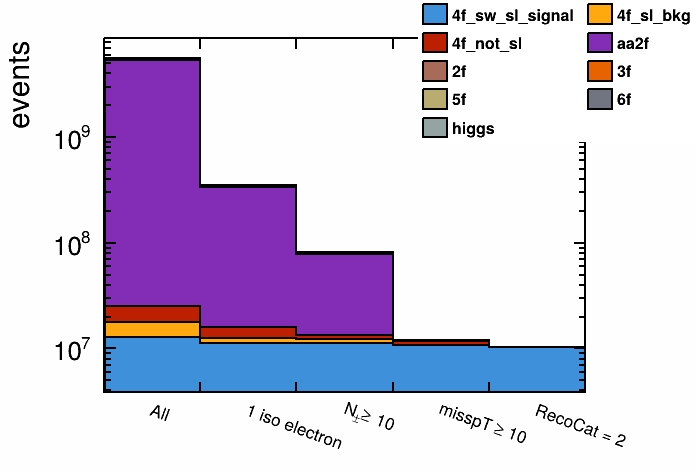

In [16]:
analysis.print_reports()
analysis.draw_cutflow(plot_dir=plot_dir)

(<cppyy.gbl.THStack object at 0x22ab78d0>,
 <cppyy.gbl.TCanvas object at 0x2195fab0>)

Info in <TCanvas::Print>: pdf file plots/pre-selection/test/('n_isoelectrons', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/test/('n_charged_PFOs', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/test/('misspT', 5000, 0.0, 0.0).pdf has been created
Info in <TCanvas::Print>: pdf file plots/pre-selection/test/('RecoCatAdvanced', 5000, 0.0, 0.0).pdf has been created


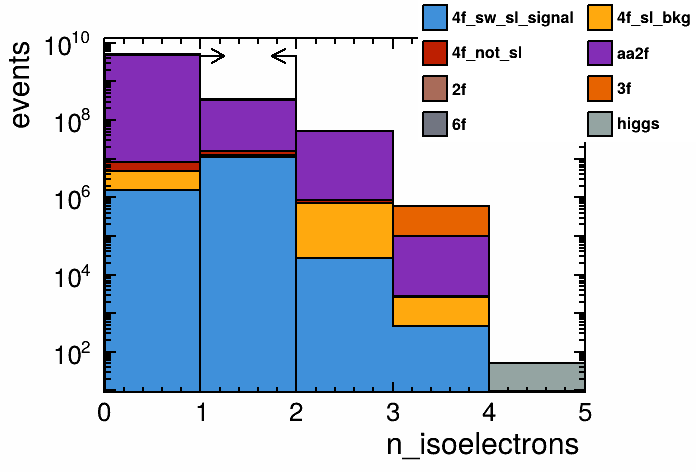

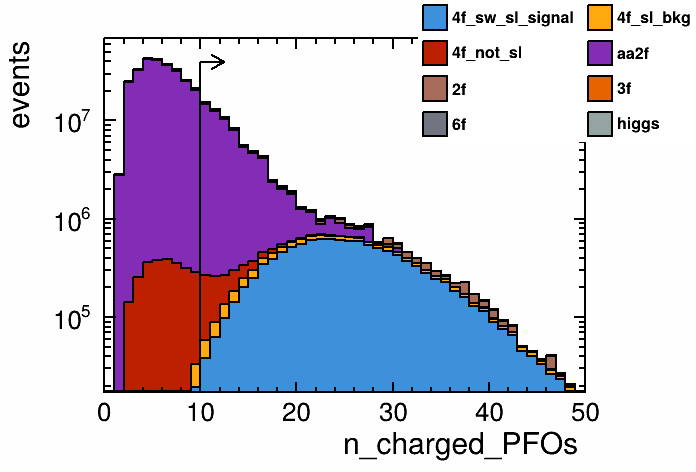

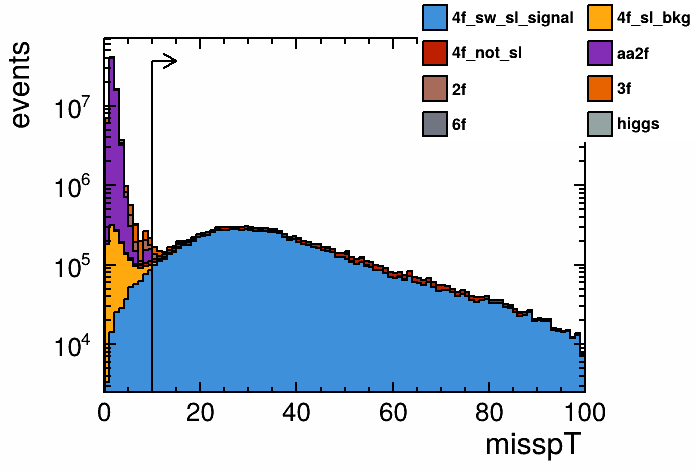

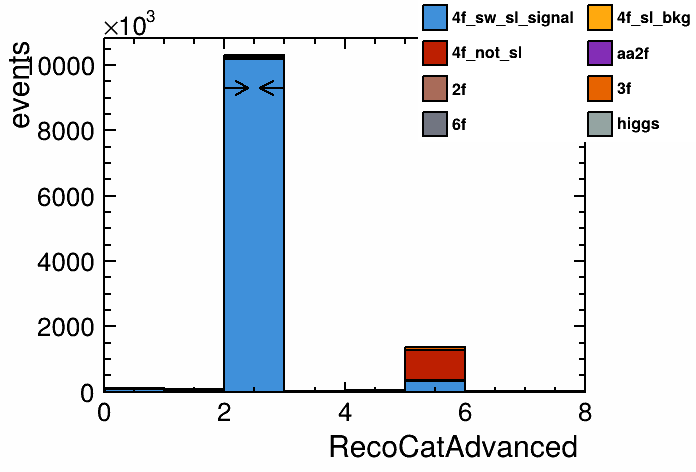

In [17]:
# unfortunately the jsroot plots break all the time, maybe it is just too much for them
# %jsroot on
# 0 - hadronic (both W decay hadronically)
# 1 - invisible semileptonic (one W decays hadronically, but the lepton is not within detector acceptance/detected)
# 2 - semileptonic electron
# 3 - semileptonic muon
# 4 - semileptonic tauon
# 5 - leptonic (both W decay leptonically)
# 6 - other, 7- broken?
# analysis.draw_histogram("RecoCatBasic")
analysis.draw_histogram("n_isoelectrons", logY=True, plot_dir=plot_dir, x_arrowl=1.0, x_arrowr=2.0)
analysis.draw_histogram("n_charged_PFOs", logY=True, plot_dir=plot_dir, x_arrowl=10.)
analysis.draw_histogram("misspT", logY=True, plot_dir=plot_dir, x_arrowl=10.)
analysis.draw_histogram("RecoCatAdvanced", plot_dir=plot_dir, x_arrowl=2., x_arrowr=3.)

(<cppyy.gbl.THStack object at 0x22c309a0>,
 <cppyy.gbl.TCanvas object at 0x22c5f480>)

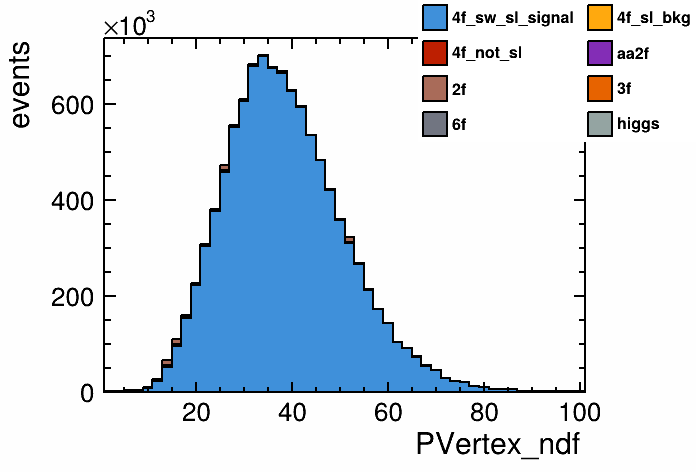

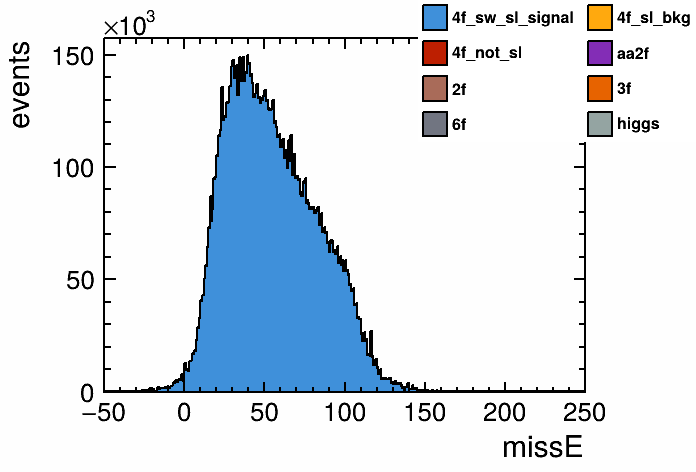

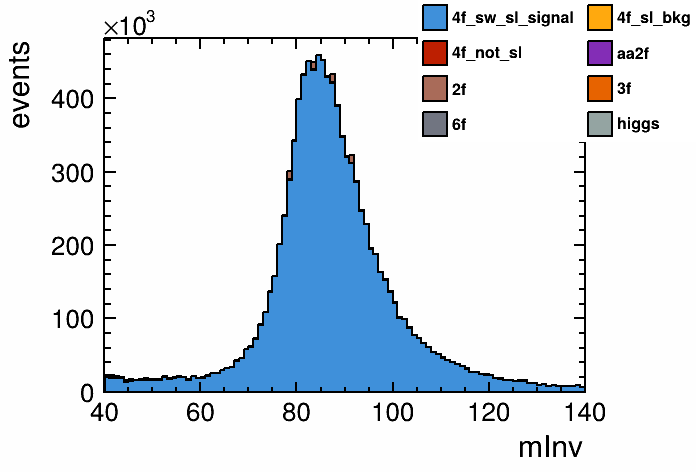

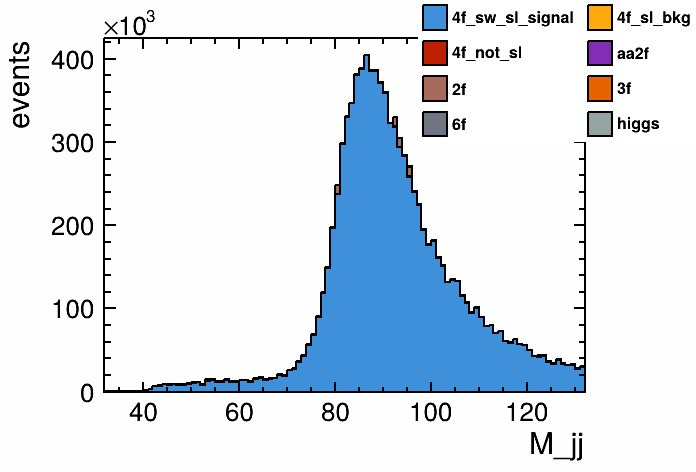

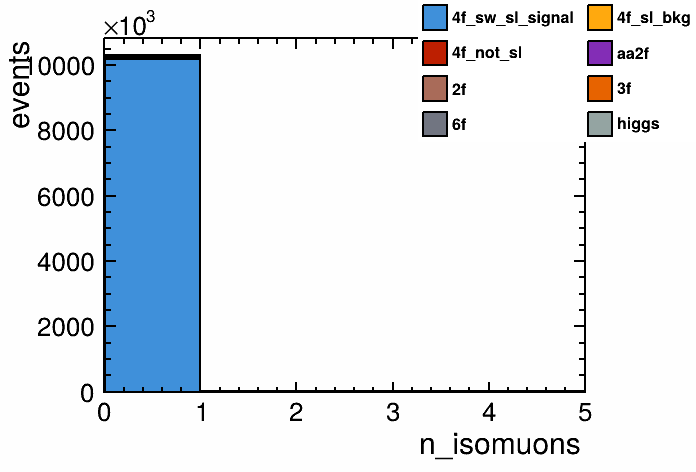

In [18]:
analysis.draw_histogram("PVertex_ndf")

analysis.draw_histogram("missE")
analysis.draw_histogram("mInv")
analysis.draw_histogram("M_jj")
analysis.draw_histogram("n_isomuons")

(<cppyy.gbl.THStack object at 0x22533b90>,
 <cppyy.gbl.TCanvas object at 0x224aa360>)

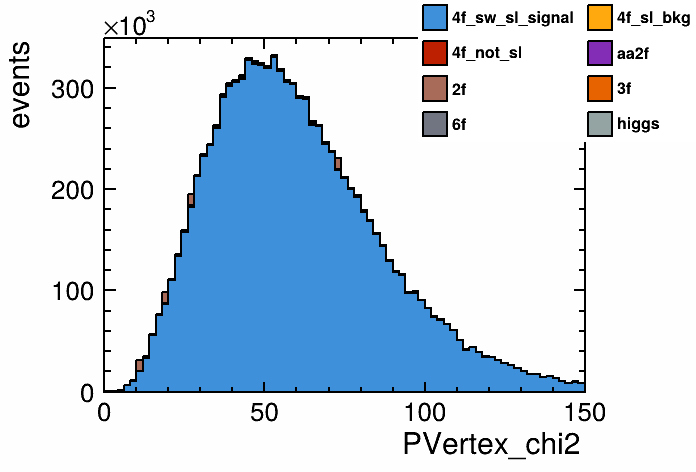

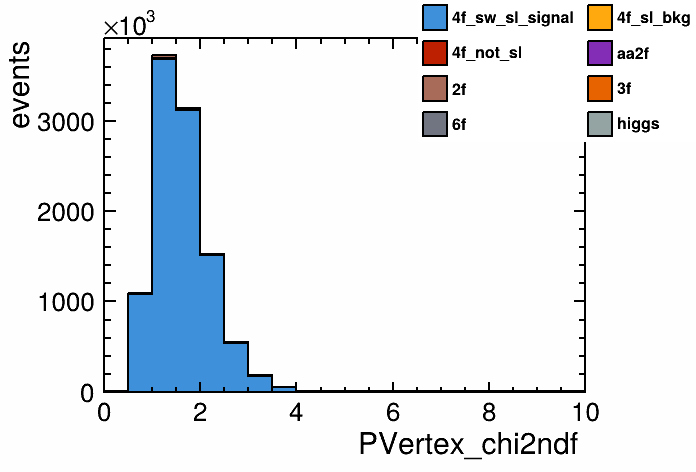

In [19]:
analysis.draw_histogram("PVertex_chi2")
analysis.draw_histogram("PVertex_chi2ndf")

In [20]:
# TODO: plot the 5 (10?) differential cross sections down here